<a href="https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/tf-v2/U3-M10-final-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our final model

## Converted to TensorFlow 2

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.22.0


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [5]:
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [6]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [7]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   205k      0 --:--:-- --:--:-- --:--:--  205k


In [0]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [11]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000
std,17.604333,17.130400,15.250815
min,68.000000,16.000000,1.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,100.000000,84.000000


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

def plot_history(history, samples=100, init_phase_samples=None, 
                 size=(20, 10),
                 plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=size)

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [16]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

num_categories = 3
dropout = 0.6
model = tf.keras.Sequential()

model.add(Dense(100, name='hidden1', input_dim=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

In [17]:
%%time 

BATCH_SIZE=1000
EPOCHS = 2000

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 43.1 s, sys: 3.4 s, total: 46.5 s
Wall time: 1min 6s


In [18]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 14us/sample - loss: 0.5002 - accuracy: 0.8089


(0.500191330909729, 0.8088889)

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 7us/sample - loss: 0.5358 - accuracy: 0.7900


(0.5357955098152161, 0.79)

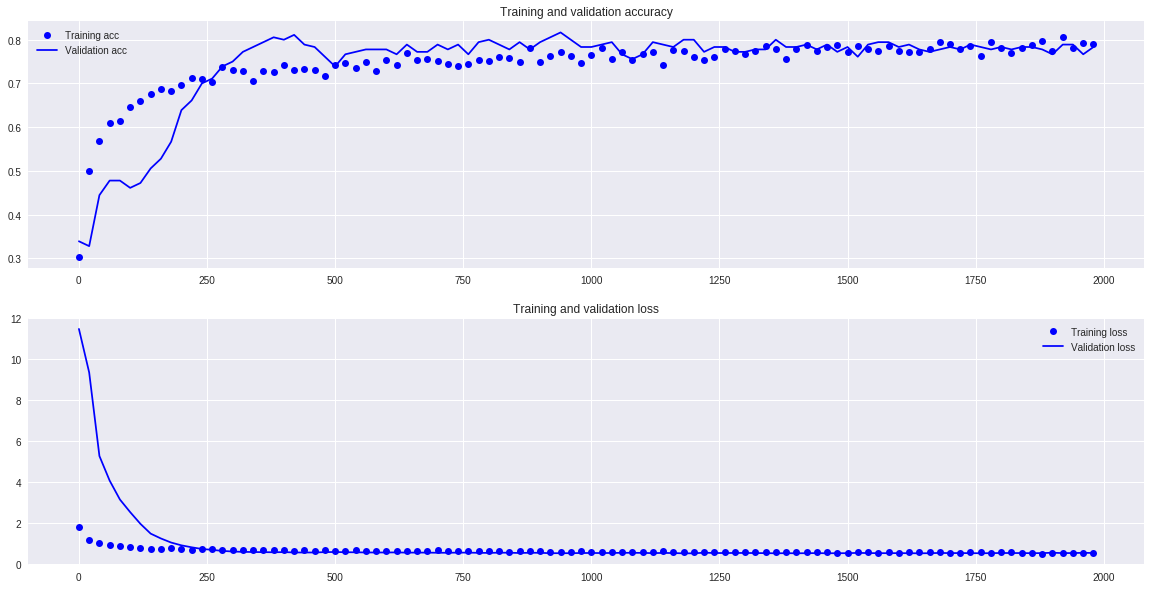

In [20]:
plot_history(history)

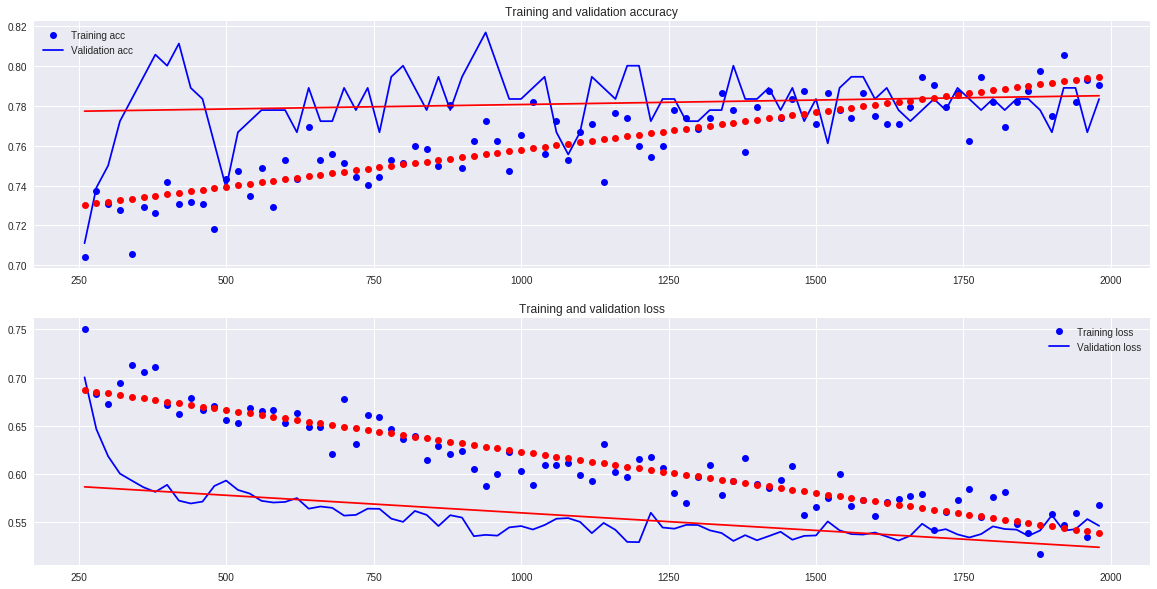

In [21]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [0]:
model.save('insurance.h5')

In [23]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.h5

-rw-r--r-- 1 root root 188280 Mar  7 08:02 insurance.h5
